# Information Retrieval Lab, Session 5: Network Analysis


## 2. Building and Analyzing Our Own Network

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

import networkx as nx
from requests_html import HTMLSession # for google news source

import spacy
from spacy import displacy

# load 'en_core_web_sm' from spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

# init HTMLSession instance
session = HTMLSession()

def fetch_article(url):
    '''  '''
    page = session.get(url)
    return ' '.join(paragraph.text for paragraph in page.html.find('p'))


def clean_text(text):
    '''  '''
    return ' '.join(token.lower() for token in text.split() if token.lower() not in stopwords)
    

def get_news(topic, n_top=10, session=session):
    '''  '''
    url = 'http://news.google.com/rss/search?q={}'.format(topic)
    page = session.get(url)

    news_dict = {
        'title':[title.text for title in page.html.find('title')[1:n_top]],
        'url':[link.html[7:] for link in page.html.find('link')[1:n_top]]
    }

    # search summary
    n_titles = len(news_dict['title'])
    n_urls = len(news_dict['url'])
    print(f'extracting news for topic: {topic}')
    print(f'n_title = {n_titles} ... n_urls = {n_urls}')

    news_df = pd.DataFrame(news_dict)
    news_df['body'] = news_df['url'].apply(lambda x: fetch_article(x))

    # clean article text
    news_df['title'] = news_df['title'].apply(lambda x: clean_text(x))
    news_df['body'] = news_df['body'].apply(lambda x: clean_text(x))

    news_df.drop('url', axis=1, inplace=True)

    news_df.to_csv('../data/financial/raw/{}_news.csv'.format(topic), index=False)


# custom lists of topics to scrape
topics_list = [
    'META', 'AAPL', 'AMZN', 'TSLA', 'GOOG', 'MSFT', 'TSM' # BIG TECH COMPANIES
]

for topic in topics_list:
    get_news(topic, n_top=5)

# merge all news into single .csv file and export to 'data/interim/...'
all_news_files = [file for file in os.scandir('data/financial/raw') if '.csv' in file.name]

all_news_df = pd.DataFrame()

for file in all_news_files:
    df = pd.read_csv(file)
    all_news_df = pd.concat([all_news_df, df])

# dropping empty observations
all_news_df = all_news_df.dropna() 

# clean up indices and export to .csv
all_news_df.reset_index(inplace=True)
all_news_df.drop('index', axis=1, inplace=True)
all_news_df.to_csv('../data/interim/all_news.csv', index=False) # export to 'data/interim/...'

In [278]:
all_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   28 non-null     object
 1   body    28 non-null     object
dtypes: object(2)
memory usage: 576.0+ bytes


### Text Preprocessing & Named Entity Recognition w/ Spacy

In [332]:
# import all_news.csv
all_news_df = pd.read_csv('../data/financial/all_news.csv')

def clean_entities(text):
    '''  '''
    text = text.replace("'", ' ')
    return text.replace('.com', '').replace('.', '').replace(',', '')


def get_relationships(doc, window_size=5):
    '''  '''
    doc = nlp(doc)

    # identifying named entities
    entity_list = []
    sent_entity_df = []
    for sent in doc.sents:
        
        for ent in sent.ents:
            if ent.label_ in ['ORG', 'GPE']:
                entity_list.append(ent.text.split(' ')[0])
            elif ent.label_ in ['PERSON']:
                entity_list.append(ent.text)
        
        sent_entity_df.append({'sentence': sent, 'entities': entity_list})

    sent_entity_df = pd.DataFrame(sent_entity_df)

    # creating entity relationships
    relationships = []
    for i in range(sent_entity_df.index[-1]):
        end_i = min((i + window_size), sent_entity_df.index[-1])
        ent_list = sum((sent_entity_df.loc[i: end_i].entities), [])

        # Removing duplicated entities that are next to each other
        ent_unique = [ent_list[i] for i in range(len(ent_list)) if (i==0) or ent_list[i] != ent_list[i-1]]

        if len(ent_unique) > 1:
            for idx, a in enumerate(ent_unique[:-1]):
                b = ent_unique[idx + 1]
                relationships.append({'source': a, 'target': b})

    relationships_df = pd.DataFrame(relationships)

    # clean entities text
    relationships_df['source'] = relationships_df['source'].apply(lambda x: clean_entities(x))
    relationships_df['target'] = relationships_df['target'].apply(lambda x: clean_entities(x))

    relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns=relationships_df.columns)
    relationships_df['value'] = 1
    # unknown error fix
    try:
        relationships_df = relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum()
    except:
        return pd.DataFrame()

    return relationships_df


all_relationships_df = pd.DataFrame()
#for i in range(0, len(all_news_df)):
for i in range(all_news_df.index[-1]):
    df = get_relationships(all_news_df['body'][i])
    all_relationships_df = pd.concat([all_relationships_df, df])


In [333]:
all_relationships_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  335 non-null    object
 1   target  335 non-null    object
 2   value   335 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.5+ KB


## Graph Analysis and Visualization

In [334]:
# create a graph from pandas dataframe
G = nx.from_pandas_edgelist(
    all_relationships_df,
    source='source',
    target='target',
    edge_attr='value',
    create_using=nx.Graph()
)

<AxesSubplot: >

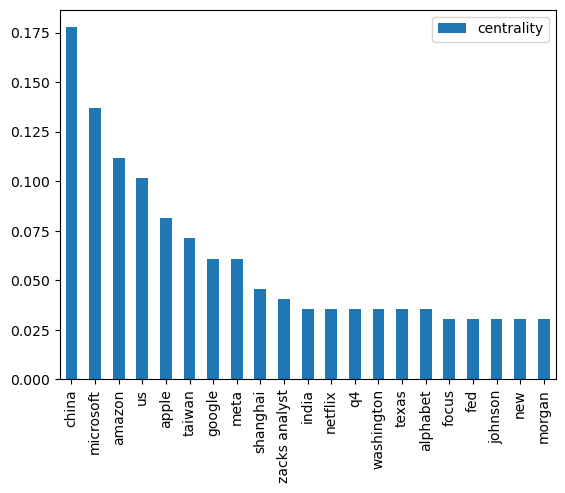

In [335]:
# degree centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

# plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:21].plot(kind='bar')

In [ ]:
from pyvis.network import Network
import community as community_louvain

# setting up node size attribute
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

# setting up node group attribute
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')

net = Network(notebook=True, cdn_resources='in_line', width='1900', height='1200', bgcolor='#222222', font_color='white')
net.force_atlas_2based() # set physics ... maybe barnes_hut()

net.from_nx(G)
net.show('../pyvis/financial_news.html') # needs work!!!